<a href="https://colab.research.google.com/github/zachroyer/Music-Symbol-Classification/blob/main/HW7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
#@title Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Part 1: Load/Analyze Data

##What is your dataset? Please describe your dataset and where you got it

My dataset of choice is titled "Music Notes Dataset". I obtained it on Kaggle uploaded by a user 'kishanj'.

## Description of Music Notes Dataset
This dataset contains a large set of one category of notes one might encounter while examining sheet music.

One image can correspond to the following labels:
*  Whole
*  Half
*  Quarter
*  Eighth
*  Sixteenth

Each note can be broken down in to three components (or a lack of one or more):
1.   Note Head
2.   Stem
3.   Flag

INSERT IMAGE

The change of these components is what determines how *long* a note is held for when playing it. The placement of the note determines *which* note to play on your desired instrument. This dataset omits that implicit feature by isolating the images to the features of a note, not its placement.

The Note Head is the circular portion of the note.
The Stem is the thin line that grows from the Note Head.
The Flag is the perpindicular tail on the end of a Stem.

# Self-Collected Test Data
In addition to the dataset from Kaggle, I also collected a small sample of test data myself. The data came from a digital scan of a physical copy of Minuet in D Minor (J.S. Bach) from the Schirmer's Library of Musical Classics Vol. 2066. This is a piece that I have personally studied on the piano.

With that digital scan,


##Load your dataset / Implement your dataloader

In [92]:
# Installing dataset directly from Kaggle
!pip install kagglehub

import kagglehub
path = kagglehub.dataset_download("kishanj/music-notes-datasets")
print("Downloaded to: ", path)

Using Colab cache for faster access to the 'music-notes-datasets' dataset.
Downloaded to:  /kaggle/input/music-notes-datasets


In [93]:
# Defining a Transform
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels = 1), # Guaranteeing only one color channel for efficiency
    transforms.Resize((64,64)), # Resizing image
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5)), # Normalizing pixel values to range from (0,1) and (-1,1) for stability
])

data = torchvision.datasets.ImageFolder(root=path, transform=transform) # Easily extract class information for data from directory structure using ImageFolder
print(len(data))

5000


In [114]:
BATCH_SIZE = 64

# Splitting Data into random train, validation and test splits
train_split, val_split, test_split = torch.utils.data.random_split(data, [int(len(data)*0.8), int(len(data)*0.1), int(len(data)*0.1)])

# Wrapping random data in DataLoader for PyTorch
train_loader = DataLoader(train_split, batch_size=BATCH_SIZE)
validation_loader = DataLoader(val_split, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_split, batch_size=BATCH_SIZE)

##Dataset Analyis Statistics

63
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])


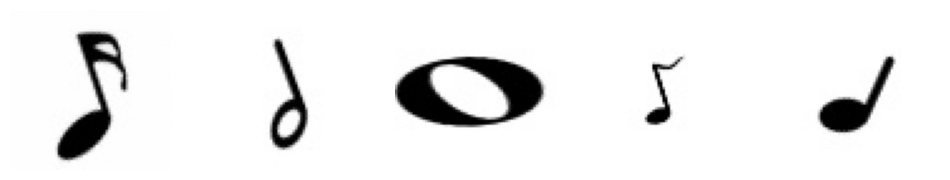

Number of data points (images) in each split (train/val/test): 63/8/8


In [115]:
# TODO - code for collecting statistics from your dataset / plots and analysis
train_iter = iter(train_loader)
print(len(train_iter))

fig, axes = plt.subplots(1, 5, figsize=(12,3))

for i in range(5):
  images, labels = next(train_iter)
  print(images.shape)
  img = images[i].squeeze().numpy()
  axes[i].imshow(img, cmap="gray")
  axes[i].axis("off")

plt.show()

print(f"Number of data points (images) in each split (train/val/test): {len(train_loader)}/{len(validation_loader)}/{len(test_loader)}")


# Analysis

A description of the dataset
● Format of the inputs and outputs
● Number of examples in the train/val/test splits
● A visualization of at least 5 examples from your dataset
Summary statistics (e.g. for language datasets, you might include things such as the average lengths
of the inputs or the number of unique words).
● If possible, any visualizations of the dataset statistics.

## Format


# Part 2: Literature Review

In my research, I identified three academic sources that may prove relevant to my exploration of music note classification, and the strengths and weaknesses of machine learning, specifically convolutional neural networks.

In the first paper from (Lee et al. 2016), the researchers wanted to tackle the first stages in a broader field known as Optical Music Recognition (OMR). OMR, as it is stated, has vast practical applications for the digitization of sheet music. The first step in OMR is note classification. The Lee et al. used a large dataset of handwritten musical characters known as HOMUS, and ran experiments on classification using a number of techniques, although I am most interested in the machine learning ones.

The research team trained multiple Multi-Layer Perceptron (MLP) and Convolutional Neural Network (CNN) models. The first and most important hyperparameter the team narrowed down was their activation function. They verified that a ReLU activation function is better suited than a Sigmoid activation in this instance.


Across all architectures, however, the size of the images and size of the kernels seemed to have the biggest effect on the accuracy of a model. For example, an increase of image resolution of a single note from 32x32 to 224x224 improved MLP accuracy by almost 5%. I am not at the liberty to increase resolution or size of my input data, but I can always adjust my kernel size and padding in my CNN architecture. For an image size of 64x64, a 2x2 kernel was used (32:1 ratio). This size to kernel ratio stayed consistent across architectures.

Lee et al. determined that CNN models, particularly ones model after GoogleNet, outperformed any other machine learning / mathematical model.


The next paper I studied only reinforced this research. In Section IV of A CNN-Based Optical Music Recognition Method (J. Chen et al. 2024), the researchers found that CNNs were the preferred model for long-term stability and accuracy. They gave deeper numerical details regarding their CNN architecture: A learning rate of 0.0001 and a batch size of 64. I think it would be wise for me to tune my hyperparameters of their findings. With their CNN model, they acheived over 99% accuracy.

One thing to note from this paper does not explicitly state what dataset they are using, but do clarify that they train their models on digital sheetmusic, not handwritten notes like the previous paper. They also talk extensively on removing 'noise' in traditional sheet music (staffs, cleffs, accidentals), although this is a deeper OMR topic that does not apply to my classification inquiry.


The aforementioned papers both talk about different types of musical characters (handwritten and printed/digital). Seeing as my dataset from Kaggle is exclusively printed/digital musical characters which are pre-processed, I do fear whatever model I train will be insufficient on handwritten notes or even notes that haven't been pre-processed and still include sheet-music "noise".


The final paper I examined, "Towards a Universal Music Symbol Classifier" (A. Pacha and H. Eidenberger (2017), took a different approach to the problem. These researchers also examined that there was an imbalance of OMR classifier models that leaned towards handwritten or digital characters, but not both. A. Pacha and H. Eidenberger took on the task of synthesizing Music Symbol datasets to create a 'universal' set which contains musical characters of many varieties (79 classes) in both handwritten and digital formats.

While they did not offer specifics on their model architecture, they did report an impressive 98% accuracy on test data. This mostly proves that data is king, but I found it relevant to my exploration.

### Summary of research
(Lee, Sangkuk & Son et al. 2016)
- Trained models using Multi-Layer Perceptron and several CNN Architectures
- Found for MLP and CNNs that ReLU gave better results over Sigmoid
- Discovered that higher image input sizes results in higher accuracy
- for a 224x224 size image, their kernal was 7x7, and for 64x64 (size of my dataset input), they chose a kernal of 2x2. This is a ratio of 32:1 for image:kernel size (FOR MLP)
- The GoogLeNet architecture outperformed all other models for this data type
- They conclude that CNNs can be powerful in music note classification


(J. Chen et al. 2024)
- Relevant work is in Section IV
- Discovered that CNNs outperform many other multi-layer architectures with stability and accuracy.
- Acheived highest model accuracy with hyperparameters:
  - learning_rate = 0.0001
  - batch_size = 64


**References**

A. Pacha and H. Eidenberger, "Towards a Universal Music Symbol Classifier," 2017 14th IAPR International Conference on Document Analysis and Recognition (ICDAR), Kyoto, Japan, 2017, pp. 35-36, doi: 10.1109/ICDAR.2017.265.
https://ieeexplore.ieee.org/document/8270207 (Accessible via University of Utah login)

J. Chen, W. Gao and K. Zhang, "A CNN-Based Optical Music Recognition Method," 2024 International Conference on Computers, Information Processing and Advanced Education (CIPAE), Ottawa, ON, Canada, 2024, pp. 283-287, doi: 10.1109/CIPAE64326.2024.00056. https://ieeexplore.ieee.org/abstract/document/10788279 (Accessible via University of Utah login)

Lee, Sangkuk & Son, Sung & Oh, Jiyong & Kwak, Nojun. (2016). Handwritten Music Symbol Classification Using Deep Convolutional Neural Networks. 1-5. 10.1109/ICISSEC.2016.7885856. https://www.researchgate.net/publication/315854248_Handwritten_Music_Symbol_Classification_Using_Deep_Convolutional_Neural_Networks (Accessible via University of Utah login)



# Part 3: Implement networks in PyTorch

Note of warning here: Depending on how easily you can allocate GPU resources, you may want to make your network much shallower so that you can train it more easily
Aim to have one gradient update take no more than a few seconds
May also want to reduce the number of training steps if training is too slow

In [87]:
LEARNING_RATE = 0.0001

In [110]:
# Defining CNN class
class MusicCNN(nn.Module):
  def __init__(self):
    super().__init__()

    #Initializing layers/components for CNN
    self.relu = nn.ReLU()

    # Defining convolutional layers
    self.conv1 = nn.Conv2d(1, 6, kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(6, 16, kernel_size=2, stride=1)

    # This halves the HxW Tensor size
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    # Defining fully connected layers
    self.fc1 = nn.Linear(784, 256)
    self.fc2 = nn.Linear(256, 64)
    self.fc3 = nn.Linear(64, 5)

    self.dropout = nn.Dropout()

  # Desigining the CNN architecture
  def forward(self, x):

    # First convolutional layer pass and max pool
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)
    x = self.relu(x)

    # Second convolution and max pool pass
    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)
    x = self.relu(x)

    # Flattening data to be passed to FC layer
    x = torch.flatten(x, 1)

    # First fully connected layer
    x = self.fc1(x)
    x = self.relu(x)

    # Applying dropout to reduce noise with p=0.5 (default)
    x = self.dropout(x)

    # Second fully connected layer
    x = self.fc2(x)
    x = self.relu(x)

    # Third fully connected layer reducing to classification size
    x = self.fc3(x)

    # Applying a softmax to get probability distribution
#    x = nn.functional.log_softmax(x, dim=1)

    return x



In [111]:
# Instantiating model and putting it on GPU
model = MusicCNN().to(device)

# Defining a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), LEARNING_RATE)

In [113]:
# Temporary cell to find layer sizes
temporary_iter = iter(train_loader)
images, labels = next(temporary_iter)
images = images.to(device) # Moving The test batch to the CPU

print("Running one forward pass to find the shape:")
with torch.no_grad():
    output_features = model(images)

print(output_features[0])


Running one forward pass to find the shape:
tensor([-1.6749, -1.6548, -1.5902, -1.5525, -1.5801])


In [ ]:
# TODO - implement your training loop

In [ ]:
# TODO - plot train and validation accuracy of your model during training

Hint: look at earlier homeworks / resuse code from those to help you here

# Part 4: Run Hyperparameter Experiments

In [ ]:
# TODO - perform hyperparameter grid searches and plot accuracies

In [ ]:
# TODO - perform other experiments and plot accuracies

In [ ]:
# TODO - calculate the final test accuracy

TODO - Explain your experiments above. See assignment doc for more details.